## Koren Model Fit

In [38]:
# Step 1: Load the pickle file
with open("plate_curves.pkl", "rb") as f:
    raw_data = pickle.load(f)

# Step 2: Parse the structure into Vp_data, Vg_data, Ia_data
Vp_data = []
Vg_data = []
Ia_data = []

for key, values in raw_data.items():
    if key.startswith("gv"):
        try:
            Vg_val = float(key.replace("gv", ""))
        except ValueError:
            continue  # skip keys that aren't voltage traces
    Vp_sub_data = []
    Ia_sub_data = []
    Vg_sub_data = []
    for value in values:
        Vp, Ia = value
        Vp_sub_data.append(Vp)
        Ia_sub_data.append(Ia)
        Vg_sub_data.append(Vg_val)
    Vp_data.append(np.array(Vp_sub_data))
    Ia_data.append(np.array(Ia_sub_data))
    Vg_data.append(np.array(Vg_sub_data))

# Step 4: Define the extended Koren model function
def extended_koren_model(X, kp, kg, kv, gamma):
    Vp, Vg, mu = X
    U = mu / (2 * kv) * (Vg + Vp / mu)
    ln_term = np.log1p(np.exp(U))  # numerically stable
    P = (Vp + kp) ** 1.5
    return (P / kg) * (ln_term ** gamma)

Vp = np.linspace(0, 300, 301)
Vg_list = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
mu = 100
popts = []

for Vp, Vg, Ia in zip(Vp_data, Vg_data, Ia_data):
    # Step 5: Prepare X tuple for curve fitting
    X_data = (Vp, Vg, np.full(np.shape(Vp), mu, dtype=np.float32))
    
    # Step 6: Provide initial guess and bounds
    initial_guess = [300, 1060, 1.73, 1.3]  # kp, kg, kv, gamma
    bounds = ([10, 10, 0.1, 0.5], [1000, 10000, 10, 3.0])

    # Make sure Ia_data is in mA
    Ia_data_mA = Ia * 1000
    
    # Step 7: Fit the model (optional – remove comment to run)
    popt, _ = curve_fit(extended_koren_model, X_data, Ia_data_mA,
                        p0=initial_guess, bounds=bounds)
    
    popts.append(popt)
popts = np.nanmean(popts, axis = 0)
print([format(i, 'f') for i in popts])

['140.465386', '7232.151421', '6.947540', '1.800174']


C:\Users\khard\AppData\Local\Temp\ipykernel_18344\2555696278.py:32: RuntimeWarning: overflow encountered in exp
  ln_term = np.log1p(np.exp(U))  # numerically stable


## Main Triode Class

In [35]:
import numpy as np
import pickle
from scipy.optimize import curve_fit, least_squares
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.mplot3d import Axes3D

# Define Triode class
class Triode:
    def __init__(self, Vp_data, Ia_data, Vg_data):
        self.Vp_data = Vp_data
        self.Ia_data = Ia_data
        self.Vg_data = Vg_data
        self.gamma = None
    def three_D_manifold(self):
        # Step 2: Create interpolation grid
        self.Vp_grid, self.Vg_grid = np.meshgrid(
            np.linspace(min(self.Vp_data), max(self.Vp_data), 100),
            np.linspace(min(self.Vg_data), max(self.Vg_data), 100)
        )
        
        # Step 3: Interpolate current values over the grid
        self.Ia_grid = griddata(
            points=(self.Vp_data, self.Vg_data),
            values=self.Ia_data,
            xi=(self.Vp_grid, self.Vg_grid),
            method='linear'  # can try 'linear' or 'nearest' if sparse
        )
    def plot_three_D_manifold(self):
        # Step 4: Plot the surface
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap='viridis', linewidth=0, antialiased=True)
        
        ax.set_xlabel('Plate Voltage Vp (V)')
        ax.set_ylabel('Grid Voltage Vg (V)')
        ax.set_zlabel('Plate Current Ia (mA)')
        ax.set_title('Interpolated Plate Curve Surface')
        plt.tight_layout()
        plt.show()
    
    def extended_koren(self, Vg_list, mu):
        # Step 4: Define the extended Koren model function
        def extended_koren_model(X, kp, kg, kv, gamma):
            Vp, Vg, mu = X
            U = mu / (2 * kv) * (Vg + Vp / mu)
            ln_term = np.log1p(np.exp(U))  # numerically stable
            P = (Vp + kp) ** 1.5
            return (P / kg) * (ln_term ** gamma)
        

        popts = []
        
        for Vp, Vg, Ia in zip(self.Vp_data, self.Vg_data, self.Ia_data):
            # Step 5: Prepare X tuple for curve fitting
            X_data = (Vp, Vg, np.full(np.shape(Vp), mu, dtype=np.float32))
            
            # Step 6: Provide initial guess and bounds
            initial_guess = [300, 1060, 1.73, 1.3]  # kp, kg, kv, gamma
            bounds = ([10, 10, 0.1, 0.5], [1000, 10000, 10, 3.0])
        
            # Make sure Ia_data is in mA
            Ia_data_mA = Ia * 1000
            
            # Step 7: Fit the model (optional – remove comment to run)
            popt, _ = curve_fit(extended_koren_model, X_data, Ia_data_mA,
                                p0=initial_guess, bounds=bounds)
            
            popts.append(popt)
        popts = np.nanmean(popts, axis = 0)
        self.mu = mu
        self.kp = popts[0] # Plate voltage shaping constant
        self.kg = popts[1] # Perveance scaling factor
        self.kv = popts[2] # Exponential shaping constant
        self.gamma = popts[3] # Curvature exponent
    
    def plot_extended_koren(self, Vg_list):
        self.Ip = []
        for Vg in Vg_list:
            if not self.gamma:
                # Regular Koren Model
                E1 = np.log(1 + np.exp(self.mu * (Vg + self.Vp_grid[0, :] / self.mu) / (2 * self.kv)))
                self.Ip.append(((self.Vp_grid[0, :] + self.kp)**1.5 / self.kg) * E1**2)
            else:
                # Extended Koren Model
                P = (self.Vp_grid[0, :] + self.kp) ** 1.5
                U = self.mu / (2 * self.kv) * (Vg + self.Vp_grid[0, :] / self.mu)
                ln_term = np.log1p(np.exp(U))  # log(1 + exp(U))
                self.Ip.append((P / self.kg) * (ln_term ** self.gamma))

    def load_line(self, B_plus, cathode_resist, plate_current, pk_pk, anode_resist):
        self.B_plus = B_plus
        self.anode_resist = anode_resist # defines load line
        self.cathode_resist = cathode_resist # defines op point
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.max_current = (self.B_plus / self.anode_resist) * 1000 # b
        self.load_m = -self.max_current / self.B_plus # m
        self.Vg = -(self.plate_current / 1000) * self.cathode_resist
    # def plot_load_line():
        
    def ccs_load_line(self, plate_voltage, plate_current, pk_pk, output_impede = None):
        self.plate_voltage = plate_voltage
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        if not output_impede:
            self.load_m = 0 # m; if no output_impede specified, assume ideal ccs equivalent resistance
            self.max_current = plate_current # b

            #self.Vg = -(self.plate_current / 1000) * self.cathode_resist
        elif output_impede:
            self.output_impede = output_impede
            self.load_m = (-1 / self.output_impede) * 1000 # m; assuming output_impede << ccs equivalent resistance; x1000 to account for current in mAmps
            self.max_current = self.plate_current - (self.load_m * self.plate_voltage)
            
            #self.Vg = -(self.plate_current / 1000) * self.cathode_resist
    # def plot_ccs_load_line():


print("Done")

Done


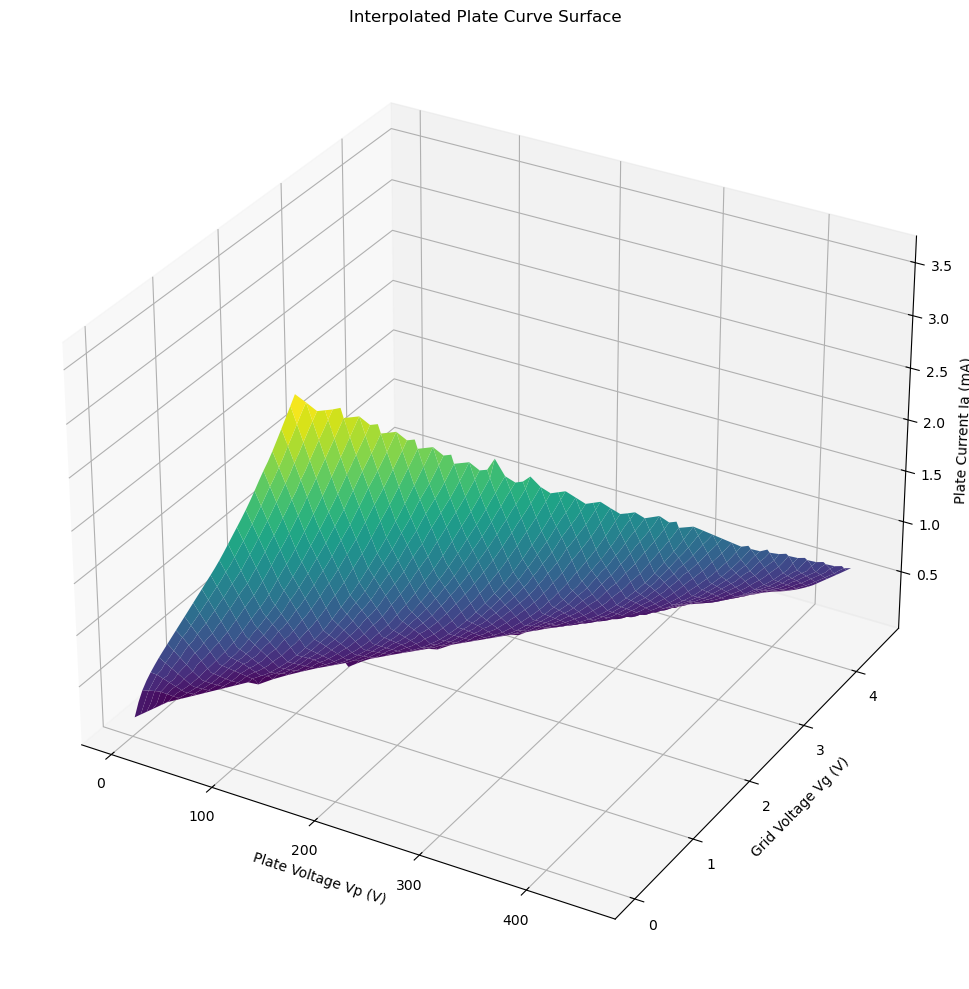

C:\Users\khard\AppData\Local\Temp\ipykernel_18344\2844376800.py:67: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(extended_koren_model, X_data, Ia_data_mA,


100 272.30312796086827 2948.8966467224072 2.6604453322289503 1.2516447333135408


In [36]:
# keys = grid voltages, values = (Vp, Ia) pairs
with open("plate_curves.pkl", "rb") as f:
    data = pickle.load(f)

# Step 1: Flatten into Vp, Vg, Ia arrays
Vp_data = []
Vg_data = []
Ia_data = []

for key, curve in data.items():
    Vg_val = float(key.replace("gv", ""))
    for Vp, Ia in curve:
        Vp_data.append(Vp)
        Vg_data.append(Vg_val)
        Ia_data.append(Ia)

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode = Triode(Vp_data, Ia_data, Vg_data)
triode.three_D_manifold()
triode.plot_three_D_manifold()

Vp = np.linspace(0, 300, 301)
Vg_list = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
mu = 100
triode.extended_koren(Vg_list, mu)
print(triode.mu, triode.kp, triode.kg, triode.kv, triode.gamma)
triode.plot_extended_koren(Vg_list)

# Basic Load Line

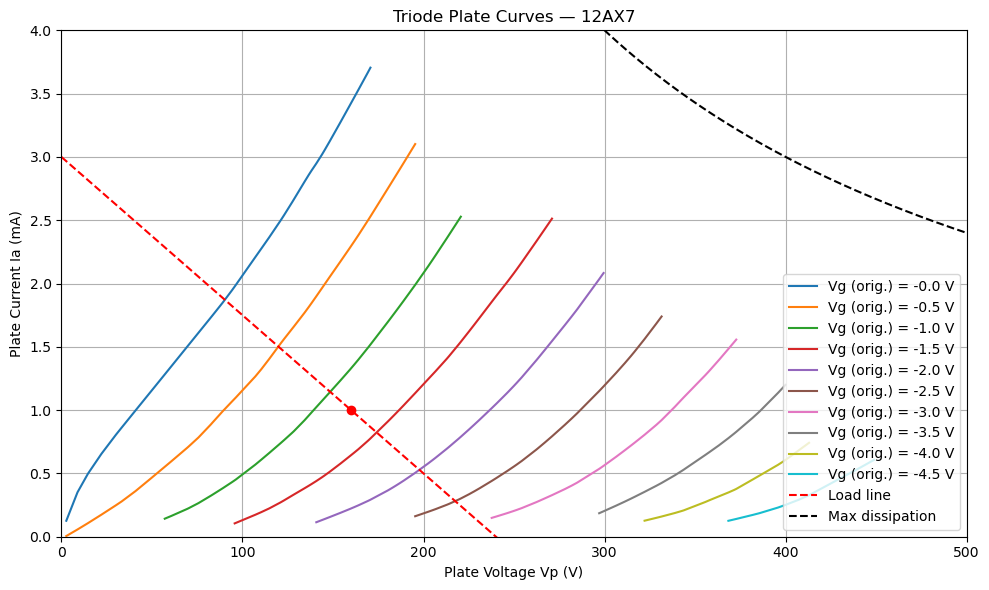

In [4]:
# Tube model parameters from optimization
mu = 100 # Amplification factor
kp = popts[0] # Plate voltage shaping constant
kg = popts[1] # Perveance scaling factor
kv = popts[2] # Exponential shaping constant

# Voltage sweep
Vp = np.linspace(0, 500, 501)
Vg_list = [-4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
triode = Triode(Vp, Vg_list, mu, kp, kg, kv)

# Plotting
plt.figure(figsize=(10, 6))

# Traced from data sheet
for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
    plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# Plot load line
triode.load_line(240, 1250, 1, 2, 80000) # plate_current in milliamps
y = triode.load_m * Vp + triode.max_current # y = mx + b
plt.plot(Vp, y, label = "Load line", color='red', linestyle='--')

# Plot operating point
pseudo_Vp_op = (triode.plate_current - triode.max_current) / triode.load_m # y = mx + b
plt.plot(pseudo_Vp_op, triode.plate_current, color='red', marker='o', linestyle = "none")

# Plot maximum dissipation
max_diss = 1.2 # Watts
plt.plot([i for i in Vp if i > 0], [max_diss * 1000 / i for i in Vp if i > 0], label = "Max dissipation", color='black', linestyle='--')

# Plot voltage swing


plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — 12AX7')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CCS Load Line

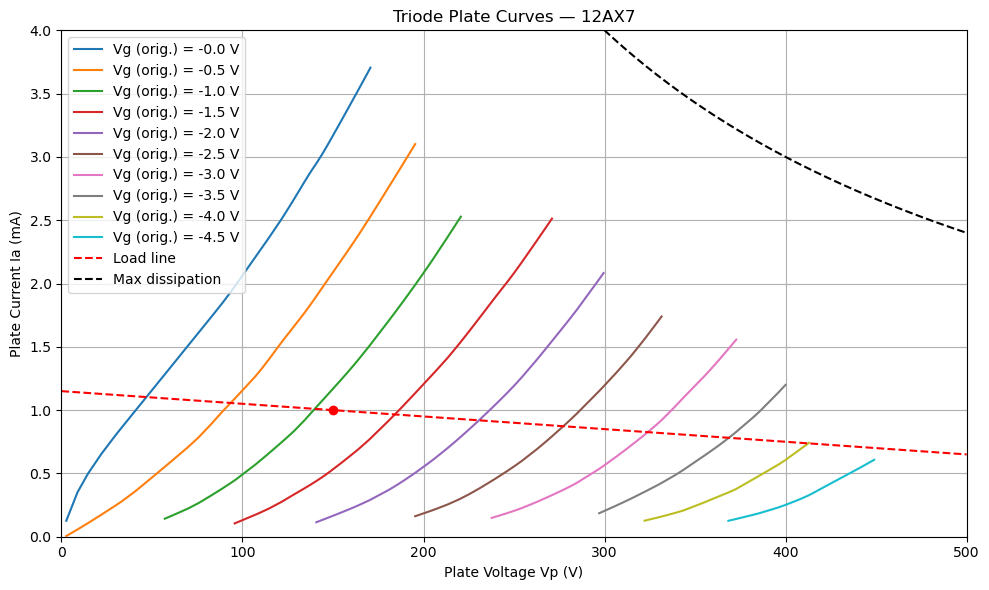

In [5]:
# Tube model parameters from optimization
mu = 100 # Amplification factor
kp = popts[0] # Plate voltage shaping constant
kg = popts[1] # Perveance scaling factor
kv = popts[2] # Exponential shaping constant

# Voltage sweep
Vp = np.linspace(0, 500, 501)
Vg_list = [-4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
triode = Triode(Vp, Vg_list, mu, kp, kg, kv)

# Plotting
plt.figure(figsize=(10, 6))

# Traced from data sheet
for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
    plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# Plot load line
triode.ccs_load_line(150, 1, 2, 1000000) # plate_current in milliamps
y = triode.load_m * Vp + triode.max_current # y = mx + b
plt.plot(Vp, y, label = "Load line", color='red', linestyle='--')

# Plot operating point
pseudo_Vp_op = (triode.plate_current - triode.max_current) / triode.load_m # y = mx + b
plt.plot(pseudo_Vp_op, triode.plate_current, color='red', marker='o', linestyle = "none")

# Plot maximum dissipation
max_diss = 1.2 # Watts
plt.plot([i for i in Vp if i > 0], [max_diss * 1000 / i for i in Vp if i > 0], label = "Max dissipation", color='black', linestyle='--')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — 12AX7')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot Best Koren Model

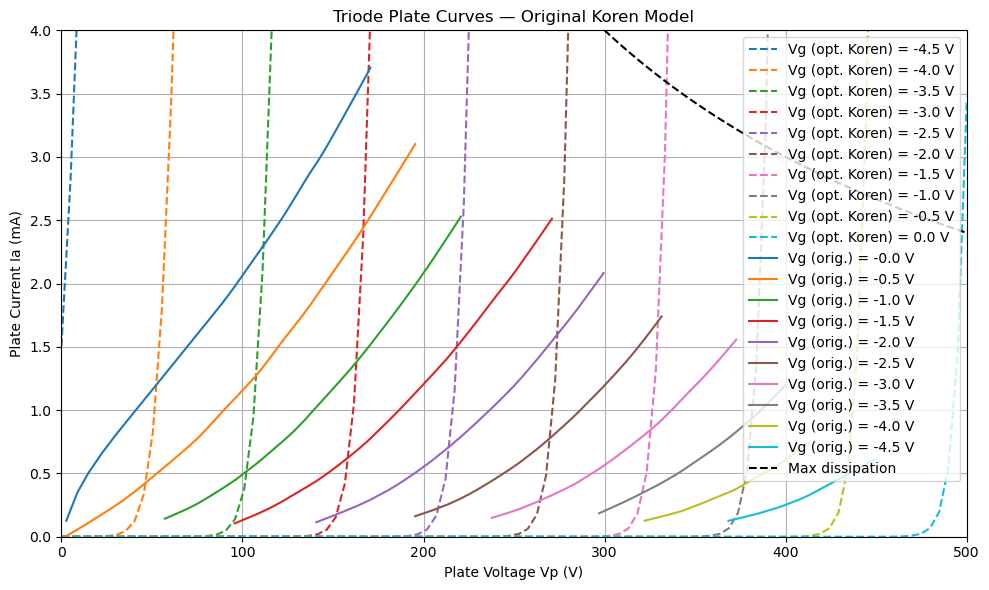

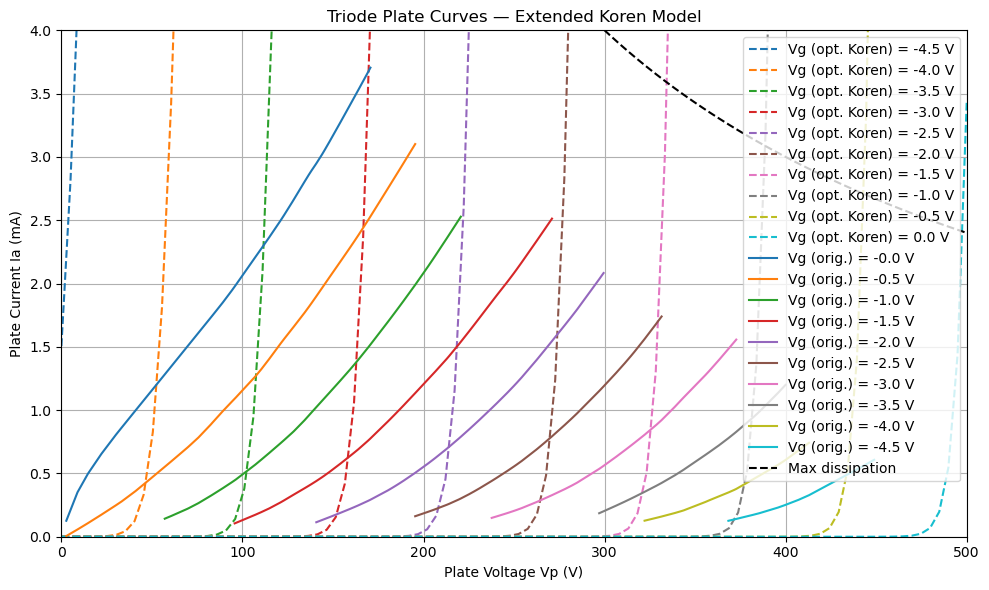

In [39]:
# Tube model parameters from optimization
mu = 100 # Amplification factor
kp = triode.kp#popts[0] # Plate voltage shaping constant
kg = triode.kg#popts[1] # Perveance scaling factor
kv = triode.kv#popts[2] # Exponential shaping constant

# Voltage sweep
Vp = np.linspace(0, 500, 100)
Vg_list = [-4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
#triode = Triode(Vp, Vg_list, mu, kp, kg, kv)

# Plotting
plt.figure(figsize=(10, 6))
# Optimized Regular Koren Model
for Vg, Ip in zip(Vg_list, triode.Ip):
    plt.plot(Vp, Ip, label=f'Vg (opt. Koren) = {Vg:.1f} V', linestyle='--')

# Traced from data sheet
for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
    plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# Plot maximum dissipation
max_diss = 1.2 # Watts
plt.plot([i for i in Vp if i > 0], [max_diss * 1000 / i for i in Vp if i > 0], label = "Max dissipation", color='black', linestyle='--')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — Original Koren Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tube model parameters from optimization
mu = 100 # Amplification factor
kp = triode.kp#popts[0] # Plate voltage shaping constant
kg = triode.kg#popts[1] # Perveance scaling factor
kv = triode.kv#popts[2] # Exponential shaping constant
gamma = triode.gamma#popts[3] # Curvature exponent
#triode = Triode(Vp, Vg_list, mu, kp, kg, kv, gamma)

# Plotting
plt.figure(figsize=(10, 6))
# Optimized Extended Koren Model
for Vg, Ip in zip(Vg_list, triode.Ip):
    plt.plot(Vp, Ip, label=f'Vg (opt. Koren) = {Vg:.1f} V', linestyle='--')

# Traced from data sheet
for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
    plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# Plot maximum dissipation
plt.plot([i for i in Vp if i > 0], [max_diss * 1000 / i for i in Vp if i > 0], label = "Max dissipation", color='black', linestyle='--')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — Extended Koren Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Main Pentode Class

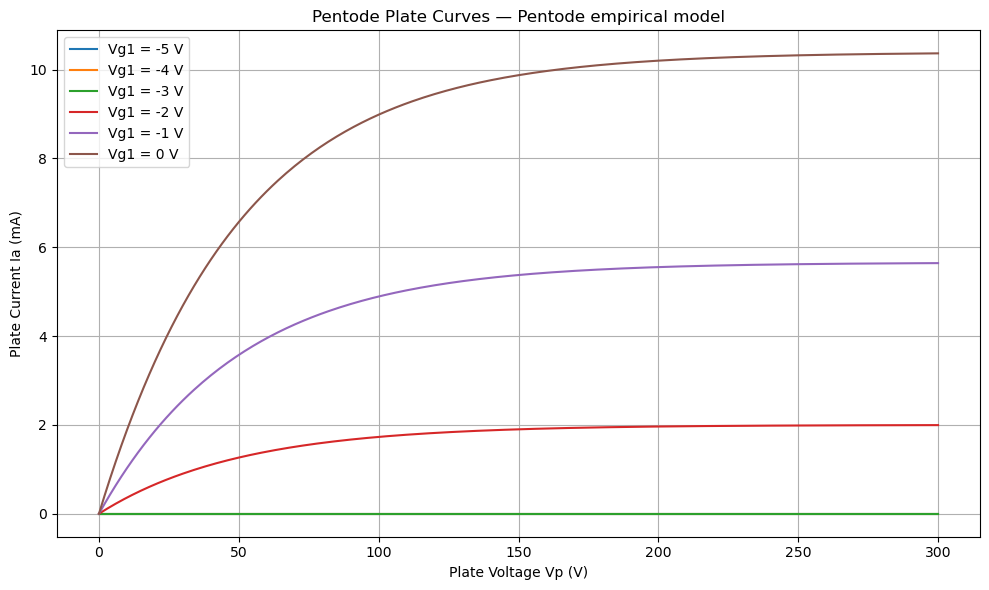

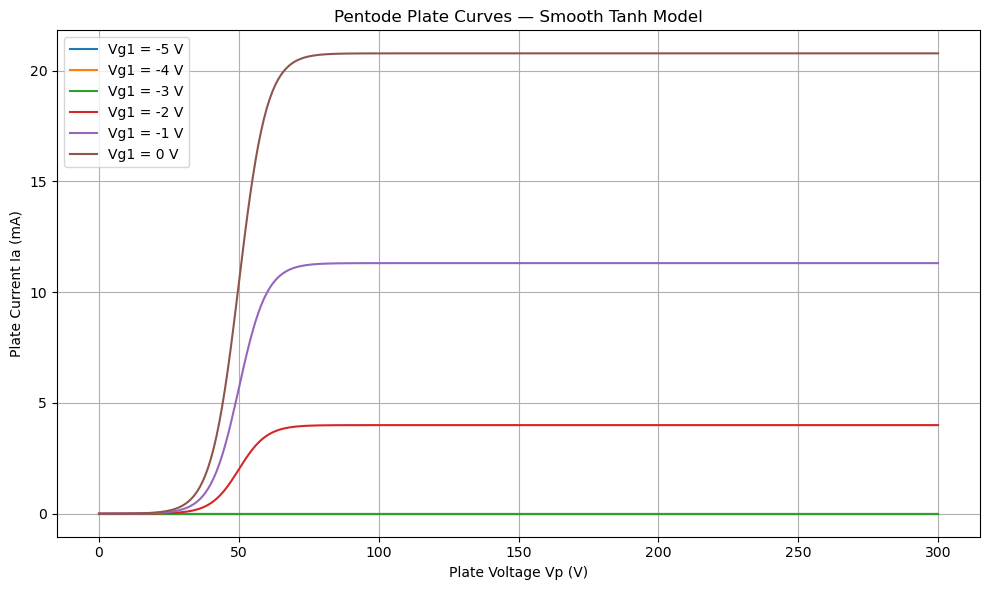

In [7]:
class CustomError(Exception):
    def __init__(self, message="An error occurred", detail=None):
        super().__init__(message)
        self.detail = detail

    def __str__(self):
         return f"{super().__str__()} (Details: {self.detail})" if self.detail else super().__str__()

class Pentode:
    def __init__(self, Vp, Vg_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = None, Vknee = None, Vslope = None):
        self.Ip = []
        for Vg1 in Vg_list:
            if Vsat and not (Vknee and Vslope):
                # Pentode empirical model
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                term1 = (Vg2 / Vg2_0) ** alpha
                term2 = Vg1_eff ** beta
                term3 = 1 - np.exp(-Vp / Vsat)
                self.Ip.append(I0 * term1 * term2 * term3)
            elif (Vknee and Vslope) and not Vsat:
                # Smoothed pentode model with tanh knee transition
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                I_sat = I0 * (Vg2 / Vg2_0)**alpha * Vg1_eff**beta
                transition = 1 - np.tanh((Vknee - Vp) / Vslope)
                self.Ip.append(I_sat * transition)
            else:
                optionals = {"Vsat": Vsat, "Vknee": Vknee, "Vslope": Vslope}
                [print(key) for key, value in optionals.items() if value is None]
                raise CustomError("Missing values", detail="Missing either " + str([key for key, value in optionals.items() if value is None]))
                
Vg2=150
I0=2.0
Vg2_0=150
Vcut=-3.0
alpha=1.0
beta=1.5
Vsat=50

# Voltage Sweep
Vp = np.linspace(0, 300, 301)
Vg1_list = [-5, -4, -3, -2, -1, 0]
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = Vsat)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Pentode empirical model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Vknee=50
Vslope=10
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vknee = Vknee, Vslope = Vslope)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Smooth Tanh Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Archive

## New Koren Model Fit

## Plot Original 12AX7 Koren Model Parameters